In [17]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.linalg import cond, matrix_rank, norm
from scipy.linalg import inv, solve, det, eig, lu, eigvals
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.svar_model import SVAR

In [18]:
#importing data
BL = pd.read_csv('Data/BankLend.csv')
consumption = pd.read_csv('Data/consumption.csv')
gdp_exp = pd.read_csv('Data/gdp.csv')
housing_starts = pd.read_csv('Data/HousingStarts.csv')
ex_rate = pd.read_csv('Data/CEER_MONTHLY_NOMINAL-sd-1990-01-01.csv') #Canadian Effective Exchange Rate - monthly nominal
SP_tbills = pd.read_csv('Data/s&p, tbills.csv')
house_prices = pd.read_csv('Data/OECD Data.csv')

In [19]:
# BANK LENDING

# Summing over rows of 3 to get quarterly data
def sum_quarter(group):
    return pd.Series({'ReferencePeriod': group['ReferencePeriod'].iloc[0],
                      'Total, funds advanced, residential mortgages, insured 7': group['Total, funds advanced, residential mortgages, insured 7'].sum(),
                      'Total, funds advanced, residential mortgages, uninsured 7': group['Total, funds advanced, residential mortgages, uninsured 7'].sum(),
                      'Total, funds advanced, variable rate mortgages': group['Total, funds advanced, variable rate mortgages'].sum(),
                      'Total, funds advanced for non-mortgage loans, consumer credit': group['Total, funds advanced for non-mortgage loans, consumer credit'].sum(),
                      'Total, funds advanced, business loans 8': group['Total, funds advanced, business loans 8'].sum()})

# Group by sets of 3 rows and average using the custom function
BankLend = BL.groupby(BL.index // 3).apply(sum_quarter)
BankLend['ReferencePeriod'] = pd.to_datetime(BankLend['ReferencePeriod'])
BankLend['Quarters'] = BankLend['ReferencePeriod'].dt.to_period("Q").astype(str)

# cleaning up the data
BankLend['BankLending'] = BankLend['Total, funds advanced, residential mortgages, insured 7'] + BankLend['Total, funds advanced, residential mortgages, uninsured 7'] +  BankLend['Total, funds advanced, variable rate mortgages'] + BankLend['Total, funds advanced for non-mortgage loans, consumer credit'] + BankLend['Total, funds advanced, business loans 8'] + BankLend['Total, funds advanced, business loans 8']
BankLend1 = BankLend[['Quarters','BankLending']]
BankLend1.head()

,Quarters,BankLending
0,2013Q1,382924.0
1,2013Q2,493784.0
2,2013Q3,483018.0
3,2013Q4,503383.0
4,2014Q1,420139.0


In [20]:
# GDP 

# keeping specific columns
gdp = gdp_exp[['Quarters', 'Gross domestic product at market prices']]

gdp.head()

,Quarters,Gross domestic product at market prices
0,2000Q1,1514676
1,2000Q2,1532503
2,2000Q3,1548212
3,2000Q4,1551274
4,2001Q1,1560006


In [21]:
# EXCHANGE RATE

# keeping one column
filtered_ex_rate = ex_rate[['date','CEER_BROADNM']]
filtered_ceer = filtered_ex_rate.reset_index(drop=True)

# Averaging over rows of 3 to get quarterly data
def average_quarter(group):
    return pd.Series({'date': group['date'].iloc[0],
                      'CEER_BROADNM': group['CEER_BROADNM'].mean()})

# Group by sets of 3 rows and average using the custom function
ceer = filtered_ceer.groupby(filtered_ceer.index // 3).apply(average_quarter).reset_index(drop=True)

# converting date to datetime format
ceer['date'] = pd.to_datetime(ceer['date'])
ceer['Quarters'] = ceer['date'].dt.to_period("Q").astype(str)

ceer = ceer.drop(['date'], axis=1)
ceer.head()

,CEER_BROADNM,Quarters
0,98.053333,1999Q1
1,101.366667,1999Q2
2,100.096667,1999Q3
3,100.486667,1999Q4
4,102.433333,2000Q1


In [22]:
# CONSUMPTION, HOUSE PRICES, HOUSING STARTS

print(consumption.head())
print(house_prices.head())
print(housing_starts.head())

  Quarters  Household final consumption expenditure
0   2000Q1                                   143884
1   2000Q2                                   145903
2   2000Q3                                   148957
3   2000Q4                                   150284
4   2001Q1                                   151594
  Quarters  House_Prices
0   2001Q1     40.844646
1   2001Q2     41.200980
2   2001Q3     41.875943
3   2001Q4     42.620664
4   2002Q1     43.340875
  Quarters  HousingStarts
0   2016Q1          38175
1   2016Q2          53286
2   2016Q3          54899
3   2016Q4          51555
4   2017Q1          42862


In [23]:
# FINANCIAL INDICATORS: S&P 500, T-BILLS

# Averaging over rows of 3 to get quarterly data
def average_quarter(group):
    return pd.Series({'nummonth': group['nummonth'].iloc[0],
                      'sp': group['sp'].mean(), 't_bills': group['t_bills'].mean()})

# Group by sets of 3 rows and average using the custom function
fin_ind = SP_tbills.groupby(SP_tbills.index // 3).apply(average_quarter).reset_index(drop=True)
fin_ind.rename(columns={'nummonth': 'Quarters'}, inplace=True)
fin_ind.head()

,Quarters,sp,t_bills
0,2013Q1,36782.440000,0.953333
1,2013Q2,36089.766667,1.010000
2,2013Q3,37059.500000,0.990000
3,2013Q4,39750.513333,0.916667
4,2014Q1,41900.943333,0.876667


In [24]:
merge1 = pd.merge(gdp, consumption, on = 'Quarters')
merge2 = pd.merge(merge1, BankLend1, on = 'Quarters')
merge3 = pd.merge(merge2, ceer, on = 'Quarters')
merge4 = pd.merge(merge3, house_prices, on = 'Quarters')
merge5 = pd.merge(merge4, housing_starts, on = 'Quarters')
final_merge = pd.merge(merge5, fin_ind, on = 'Quarters')
final_merge.rename(columns={'Gross domestic product at market prices': 'GDP', 'Household final consumption expenditure': 'CON', 'BankLending': 'BL',
                         'CEER_BROADNM':'FX', 'House_Prices': 'HP', 'HousingStarts': 'HI', 'sp':'OMX', 't_bills':'IR'}, inplace=True)
final_merge.head()

,Quarters,GDP,CON,BL,FX,HP,HI,OMX,IR
0,2016Q1,2071732,285296,495823.0,111.046667,105.128205,38175,41244.963333,0.460000
1,2016Q2,2061412,286760,579799.0,117.166667,108.601056,53286,44654.566667,0.523333
2,2016Q3,2082805,289033,586583.0,116.170000,112.826169,54899,46931.136667,0.516667
3,2016Q4,2094490,292579,575781.0,115.810000,115.803167,51555,48612.290000,0.493333
4,2017Q1,2120843,296967,539456.0,117.380000,119.193062,42862,50214.126667,0.486667


In [40]:
# Reorder the columns in line with paper
final_df = final_merge[['Quarters', 'GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']]
final_df.head()

,Quarters,GDP,CON,HI,HP,OMX,BL,FX,IR
0,2016Q1,2071732,285296,38175,105.128205,41244.963333,495823.0,111.046667,0.460000
1,2016Q2,2061412,286760,53286,108.601056,44654.566667,579799.0,117.166667,0.523333
2,2016Q3,2082805,289033,54899,112.826169,46931.136667,586583.0,116.170000,0.516667
3,2016Q4,2094490,292579,51555,115.803167,48612.290000,575781.0,115.810000,0.493333
4,2017Q1,2120843,296967,42862,119.193062,50214.126667,539456.0,117.380000,0.486667


In [41]:
final_df['Quarters'] = pd.to_datetime(final_df['Quarters'])
#final_df = final_df['Quarters'].asfreq('QS-JAN')
final_df.head()
final_df.dtypes

# Convert to float
final_df['GDP'] = final_df['GDP'].astype(int)

# Convert to int
final_df['HI'] = final_df['HI'].astype(int)

final_df.head()

C:\Users\chany\AppData\Local\Temp\ipykernel_40460\4125341605.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df['Quarters'] = pd.to_datetime(final_df['Quarters'])


,Quarters,GDP,CON,HI,HP,OMX,BL,FX,IR
0,2016-01-01,2071732,285296,38175,105.128205,41244.963333,495823.0,111.046667,0.460000
1,2016-04-01,2061412,286760,53286,108.601056,44654.566667,579799.0,117.166667,0.523333
2,2016-07-01,2082805,289033,54899,112.826169,46931.136667,586583.0,116.170000,0.516667
3,2016-10-01,2094490,292579,51555,115.803167,48612.290000,575781.0,115.810000,0.493333
4,2017-01-01,2120843,296967,42862,119.193062,50214.126667,539456.0,117.380000,0.486667


In [42]:
# List of columns to calculate log difference
columns = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Calculate log difference
for col in columns:
    final_df[col] = np.log(final_df[col]).diff()

# Print the DataFrame
final_df.head()

,Quarters,GDP,CON,HI,HP,OMX,BL,FX,IR
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-04-01,-0.004994,0.005118,0.333493,0.032501,0.079428,0.156462,0.053647,0.128992
2,2016-07-01,0.010324,0.007895,0.029822,0.038167,0.049725,0.011633,-0.008543,-0.012821
3,2016-10-01,0.005595,0.012194,-0.062846,0.026044,0.035195,-0.018587,-0.003104,-0.046213
4,2017-01-01,0.012504,0.014886,-0.184664,0.028853,0.032420,-0.065166,0.013466,-0.013606


In [43]:
# Convert DataFrame to NumPy array
endog_data = final_df[['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']].to_numpy()

# Impose Short-Term Restrictions for SVAR
B_matrix = np.array([
    [1, 'E', 'E', 0, 0, 0, 0, 0],
    [0, 1, 0, 'E', 'E', 'E', 0, 'E'],
    [0, 0, 1, 'E', 0,'E', 0, 'E'],
    [0, 0, 0, 1, 'E', 'E', 0, 'E'],
    [0, 0, 0, 0, 1, 'E', 'E', 'E'],
    [0, 0, 0, 0, 0, 1, 'E', 'E'],
    [0, 0, 0, 0, 0, 0, 1, 'E'],
    [0, 0, 0, 0, 0, 0, 0, 1],
])

# Define SVAR Model
svar_model = SVAR(endog=endog_data, svar_type='B', A=None, B=B_matrix, dates=final_df['Quarters'])

C:\Users\chany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


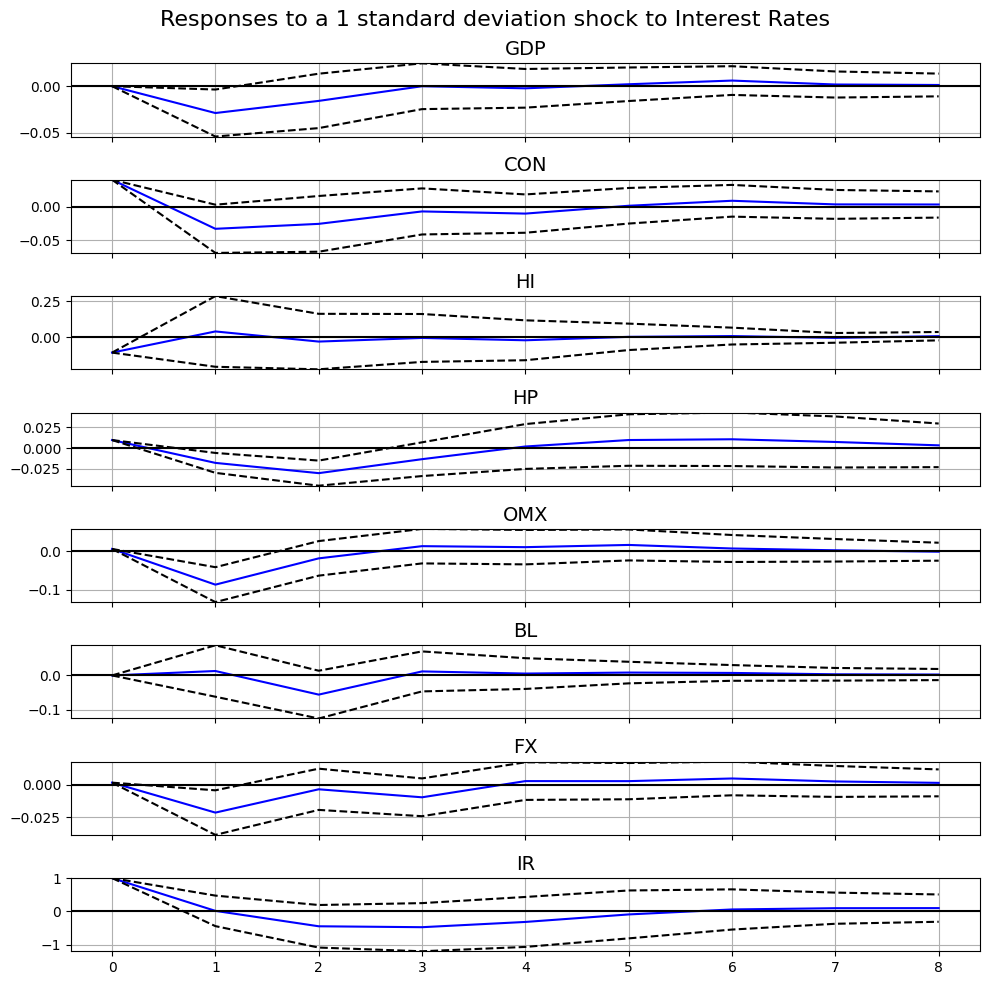

In [46]:
# Get the list of variable names in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('IR')

# Use this index for the impulse parameter
irf = result.irf(periods=8)

# Create a figure with multiple subplots
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# Loop over the axes and set the title
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

# Set the overall title
fig.suptitle('Responses to a 1 standard deviation shock to Interest Rates', fontsize=16)

plt.tight_layout()
plt.show()

In [47]:
# Get the IRFs as a numpy array
irfs_array = irf.irfs

# Create a MultiIndex for the DataFrame
index = pd.MultiIndex.from_product([range(irfs_array.shape[0]), var_names, var_names], names=['period', 'response', 'impulse'])

# Convert this array into a DataFrame
irfs_df = pd.DataFrame(irfs_array.flatten(), index=index, columns=['irf'])

# Select the 1st, 4th, and 8th quarters for 'tbills' impulse
selected_periods = irfs_df.loc[(slice(0,8,4), slice(None), 'IR'), :]


# Reset the 'impulse' level of the index
selected_periods = selected_periods.reset_index(level='impulse', drop=True)

# Unstack the 'response' level of the index
reshaped_df = selected_periods.unstack(level='response')

# Print the reshaped DataFrame
print(reshaped_df)

               irf                                                    \
response        BL       CON        FX       GDP        HI        HP   
period                                                                 
0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4        -0.016376 -0.015768 -0.008733 -0.008221 -0.014994 -0.025270   
8         0.003818  0.003702  0.002550  0.002630  0.000994  0.006648   

                              
response        IR       OMX  
period                        
0         1.000000  0.000000  
4        -0.323733 -0.007571  
8         0.019100  0.005310  


In [50]:
# Get the IRFs as a numpy array
irfs_array = irf.irfs

# Create a MultiIndex for the DataFrame
index = pd.MultiIndex.from_product([range(irfs_array.shape[0]), var_names, var_names], names=['period', 'response', 'impulse'])

# Convert this array into a DataFrame
irfs_df = pd.DataFrame(irfs_array.flatten(), index=index, columns=['irf'])

# Select the 1st, 4th, and 8th quarters for 'tbills' impulse
selected_periods = irfs_df.loc[(slice(0,8,4), slice(None), 'IR'), :]

# Reset the 'impulse' level of the index
selected_periods = selected_periods.reset_index(level='impulse', drop=True)

# Unstack the 'response' level of the index
reshaped_df = selected_periods.unstack(level='response')

# Define the table styles
table_styles = [
    {'selector': 'th', 'props': [('color', 'blue')]}
]

# Apply the table styles to the DataFrame
styled_df = reshaped_df.style.set_table_styles(table_styles)

# Display the styled DataFrame
styled_df